## 导入必要的库

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

sns.set(style='white', context='notebook')

Using TensorFlow backend.


## 数据探查

In [2]:
train = pd.read_csv('./digit-recognizer/train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test = pd.read_csv('./digit-recognizer/test.csv')
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


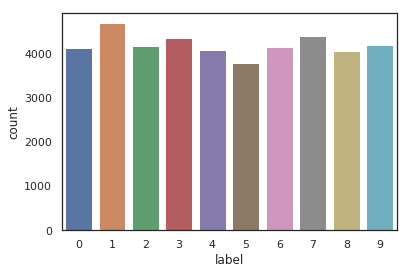

In [4]:
y_train = train['label']
X_train = train.drop(['label'], axis=1)

del train

sns.countplot(y_train)

### 检查缺失值

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

看来没有缺失值

## 特征工程

### 标准化

把像素大小从[0-255]转变到[0-1]，能够加速收敛

In [7]:
X_train /= 255.0
test /= 255.0

### 转化形状

In [8]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

### label做one-hot编码

In [9]:
y_train = pd.get_dummies(y_train).values

### 数据增强

针对手写数字这一数据集，样本本身的问题有很多，如数字的大小比例不同、“笔墨”的清淡、数字的倾斜程度甚至是存在一些噪声，如果这些样本出现在测试集而训练集里没有出现过，模型很可能误判。  
因此我们很有必要对训练集进行增强，扩充至原来的数倍以增加模型的鲁棒性  
做数据增强之前，模型跑到0.98314就基本收敛了  
做了这项操作后，模型能跑到0.99  

In [10]:
print(X_train.shape)

(42000, 28, 28, 1)


In [11]:
batch_size = 256

data_gen = ImageDataGenerator(
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # 随机旋转(0-15度)
    zoom_range = 0.1, # 随机缩放
    width_shift_range=0.1,  # 随机水平平移
    height_shift_range=0.1,  # 随机垂直平移
)

data_gen.fit(X_train)

feed_train_batch = data_gen.flow(X_train,y_train, batch_size=batch_size)

## 构建流图

In [12]:
# 定义超参数
lr = 0.001
training_iters = 5000
batch_size = batch_size
n_input = 49
n_steps = 64
n_hidden_units = 128
n_classes = 10

# 以正太分布初始化weight
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# 以0.1这个常量来初始化bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
# 池化
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

# 卷积和池化, 通过调用之前定义的weight、bias和池化函数实现
def conv_pool_layer(X, patch_len, patch_hi, out_seq):
    W = weight_variable([patch_len, patch_len, patch_hi, out_seq])
    b = bias_variable([out_seq])
    h_conv = tf.nn.relu(conv2d(X, W) + b)
    return max_pool_2x2(h_conv)

# lstm
def lstm(X):
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(
        n_hidden_units, forget_bias=1.0, state_is_tuple=True)
    _init_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
    outputs,states = tf.nn.dynamic_rnn(
        lstm_cell, X, initial_state=_init_state, time_major=False)
    W = weight_variable([n_hidden_units, n_classes])
    b = bias_variable([n_classes])
    outputs = tf.unstack(tf.transpose(outputs, [1,0,2]))
    return tf.matmul(outputs[-1], W) + b


with tf.variable_scope('input'):
    x = tf.placeholder('float32', shape=[None, 28, 28, 1])
    y = tf.placeholder('float32', shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

with tf.variable_scope('conv_pool_1'):
    h_pool1 = conv_pool_layer(x, 5, 1, 32)

with tf.variable_scope('conv_pool_2'):
    h_pool2 = conv_pool_layer(h_pool1, 5, 32, 64)

X_in = tf.reshape(h_pool2, [-1,49,64])
X_in = tf.transpose(X_in, [0,2,1])

prediction = lstm(X_in)

with tf.variable_scope('loss'):
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))

with tf.variable_scope('train'):
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## 训练

### 自定义feed_batch(仅供参考)

先训练原训练集

In [13]:
# # 随机放回抽样feed
# def sample_batch(data, batch_size):
#     if data.shape[0] < batch_size:
#         return
#     sample_data = data.sample(batch_size, replace=False, axis=0)
#     label = sample_data['label']
#     label = pd.get_dummies(label)
#     sample_data = sample_data.drop(['label'], axis=1)
#     return sample_data.values, label.values

# 顺序循环feed
def next_batch(X_data, y_data, batch_size, index):
    if X_data.shape[0] < batch_size:
        return 
    if index+batch_size >= X_data.shape[0]:
        sample_data = np.vstack([X_data[index:, :], 
                                 X_data[:index+batch_size-X_data.shape[0],:]])
        label = np.vstack([y_data[index:, :], 
                                 y_data[:index+batch_size-y_data.shape[0],:]])
        index = index+batch_size-X_data.shape[0]
    else:
        sample_data = X_data[index:index+batch_size,:]
        label = y_data[index:index+batch_size,:]
        index = index+batch_size
    return sample_data, label, index

sess = tf.Session()
sess.run(tf.global_variables_initializer())

index = 0
for i in range(training_iters):
    batch_x, batch_y, index = next_batch(X_train, y_train, batch_size, index)
    sess.run(train_step, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
    if i%100 == 0:
        print(sess.run(accuracy, feed_dict={x: batch_x, y:batch_y}))

0.1171875
0.91796875
0.97265625
0.97265625
0.98046875
0.984375
0.98828125
0.984375
0.97265625
1.0
0.9765625
0.99609375
1.0
0.9921875
0.99609375
0.99609375
0.99609375
0.99609375
1.0
0.99609375
1.0
1.0
0.99609375
1.0
0.99609375
0.99609375
1.0
1.0
1.0
1.0
1.0
1.0
0.99609375
1.0
1.0
1.0
0.99609375
1.0
1.0
1.0
1.0
0.99609375
0.99609375
1.0
1.0
1.0
1.0
1.0
1.0
1.0


训练增强数据

In [14]:
for i in range(training_iters):
    batch_x, batch_y = feed_train_batch.next()
    if batch_x.shape[0] != batch_size:
        continue
    sess.run(train_step, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
    if i%100 == 0:
        print(sess.run(accuracy, feed_dict={x: batch_x, y:batch_y}))

0.91796875
0.96484375
0.96484375
0.98046875
0.98046875
0.984375
0.984375
0.9765625
0.98046875
0.98046875
0.98828125
0.984375
0.98046875
0.98828125
0.99609375
0.98828125
0.9921875
1.0
0.984375
0.98046875
0.99609375
1.0
0.99609375
0.9921875
0.9921875
0.9921875
1.0
0.99609375
0.98828125
0.9921875
0.984375
0.9921875
0.99609375
0.98828125
1.0
0.984375
0.9921875
1.0
0.9921875
0.98828125
0.9921875
0.98828125
0.98828125
1.0
0.98828125
0.99609375
0.984375
0.99609375
0.99609375
0.99609375


## 输出预测

In [15]:
print(test.shape)

(28000, 28, 28, 1)


In [16]:
def feed_test_batch(data, batch_size, index):
    if data.shape[0] < batch_size:
        return 
    if index+batch_size >= data.shape[0]:
        sample_data = np.vstack([data[index:, :], 
                                 data[:index+batch_size-data.shape[0],:]])
        index = data.shape[0]
    else:
        sample_data = data[index:index+batch_size,:]
        index = index+batch_size
    return sample_data, index

In [17]:
test_batch_size = 256

result = []
index = 0
while index < test.shape[0]:
    batch_x, index = feed_test_batch(test, test_batch_size, index)
    result.extend(sess.run(tf.argmax(prediction, 1), feed_dict={x: batch_x}))

In [18]:
ImageId = list(range(1,len(test)+1))
result = result[:len(test)]
submit_dict = {'ImageId':ImageId, 'Label':result}
submit = pd.DataFrame(submit_dict)
submit.to_csv('submit4.csv', index=False)